In [182]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [244]:
img = cv.imread("/content/_0_9495.jpeg")

In [245]:
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

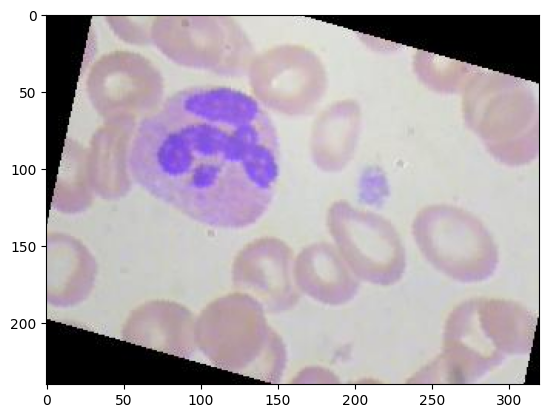

In [246]:
plt.imshow(img)

In [247]:
img.shape

(240, 320, 3)

WBC and NUCLEI SEGMENTATION

To segment WBCs and nuclei of
them, we proposed a three-part algorithm including 
1. cell segmentation, 
2. nucleus segmentation, and 
3. splitting of touching nuclei and cell.

CELL SEGMENTAION
1. preprocessing, 
2. thresholding, and 
3. morphological operations

In [248]:
import cv2
import numpy as np

# Define the RGB to CMYK conversion function
def rgb_to_cmyk(rgb):
    r, g, b = rgb/255.0
    r,g,b = r/255.0,g/255.0,b/255.0
    k = 1 - np.max([r, g, b])
    if k == 1:
        c = m = y = 0
    else:
        c = (1 - r - k) / (1 - k)
        m = (1 - g - k) / (1 - k)
        y = (1 - b - k) / (1 - k)
    return np.array([c, m, y, k])

'''# Load the RGB image using OpenCV
rgb_img = cv2.imread('my_image.jpg')'''

# Apply the RGB to CMYK conversion to each pixel using a lambda function
cmyk_img = np.apply_along_axis(lambda x: rgb_to_cmyk(x), axis=2, arr=img)

# Scale the values in the CMYK image to the range 0-255
cmyk_img = (cmyk_img*255).astype(np.uint8)

'''# Save the CMYK image using OpenCV
cv2.imwrite('my_image_cmyk.jpg', cmyk_img)'''


"# Save the CMYK image using OpenCV\ncv2.imwrite('my_image_cmyk.jpg', cmyk_img)"

In [249]:
cmyk_img.shape

(240, 320, 4)

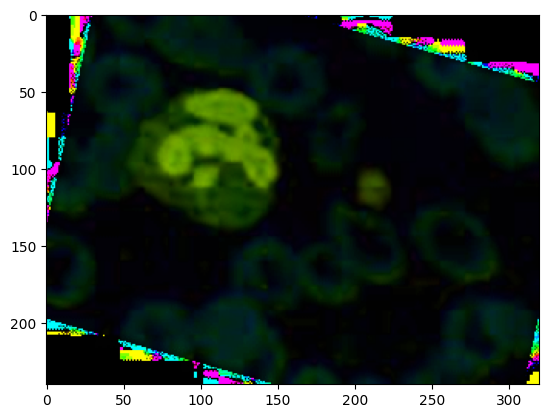

In [250]:
plt.imshow(cmyk_img)

In [251]:
c,m,y,k = cv.split(cmyk_img)

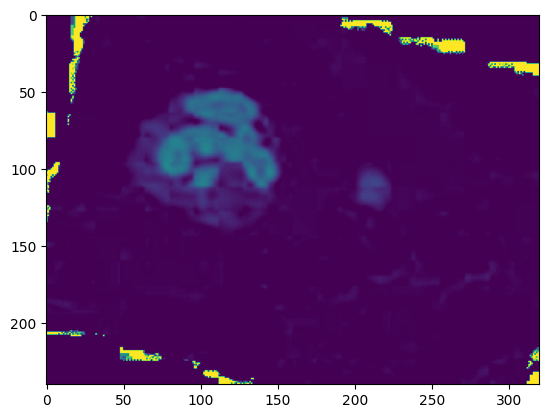

In [252]:
plt.imshow(c)

In [253]:
# Apply binary thresholding
ret, thresh = cv2.threshold(c, 60, 255, cv2.THRESH_BINARY)

# Use the thresholded image as a mask
masked_img = cv2.bitwise_and(c, c, mask=thresh)

In [254]:
masked_img.shape

(240, 320)

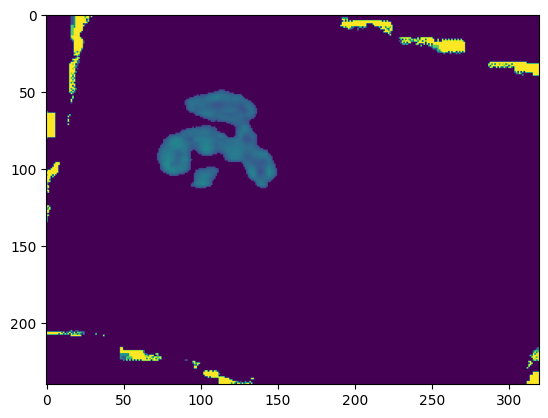

In [255]:
plt.imshow(masked_img)

Watershed Algorithm

In [256]:
# noise removal
kernel = np.ones((3,3),np.uint8)
'''opening = cv.morphologyEx(masked_img,cv.MORPH_OPEN,kernel, iterations = 2)'''
# sure background area
sure_bg = cv.dilate(masked_img,kernel,iterations=1)
# Finding sure foreground area
dist_transform = cv.distanceTransform(masked_img,cv.DIST_L2,3)
ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)

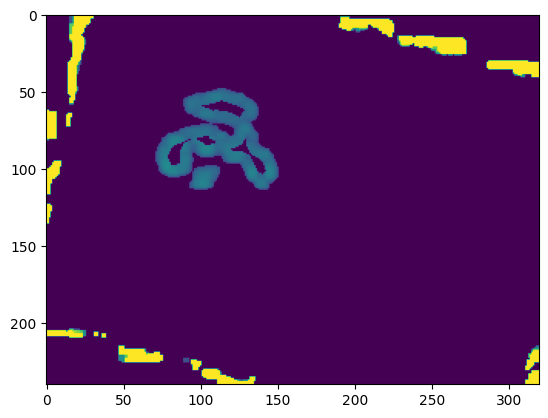

In [257]:
plt.imshow(unknown)

In [259]:
cv.imwrite("masked_image.jpg",masked_img)

True

In [260]:
img_gray = cv2.imread("masked_image.jpg",1)
img_RGB = cv.cvtColor(img_gray, cv.COLOR_BGR2RGB)
img_LAB = cv.cvtColor(img_RGB, cv.COLOR_RGB2LAB)

#img_gray = 255 -img_gray 

In [261]:
img_LAB.shape

(240, 320, 3)

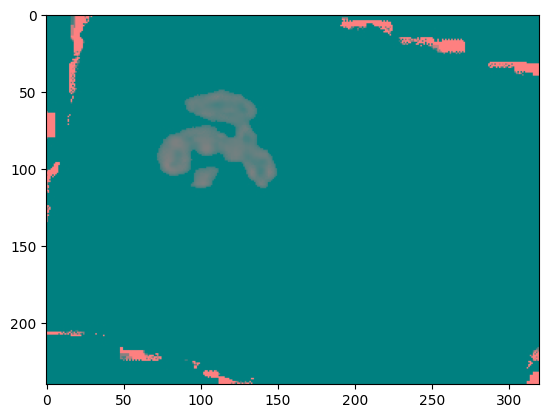

In [262]:
plt.imshow(img_LAB)

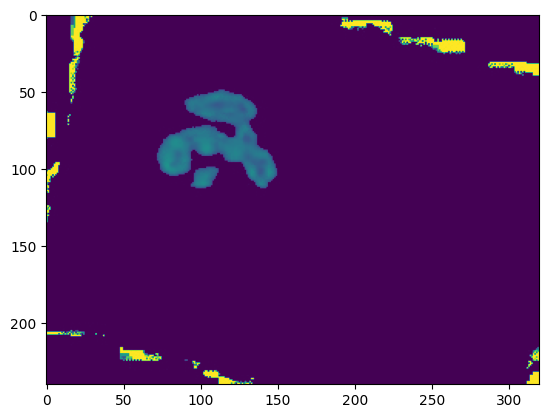

In [263]:
plt.imshow(img_LAB[:,:,0])

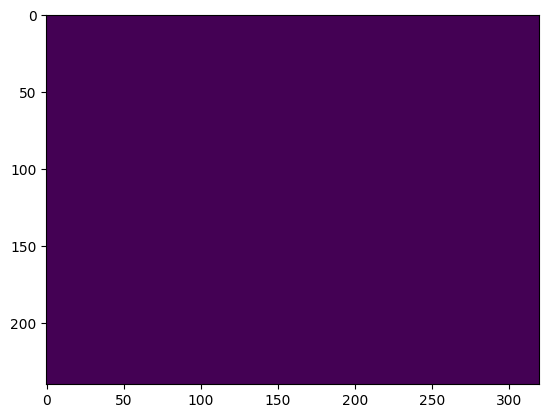

In [264]:
plt.imshow(img_LAB[:,:,1])

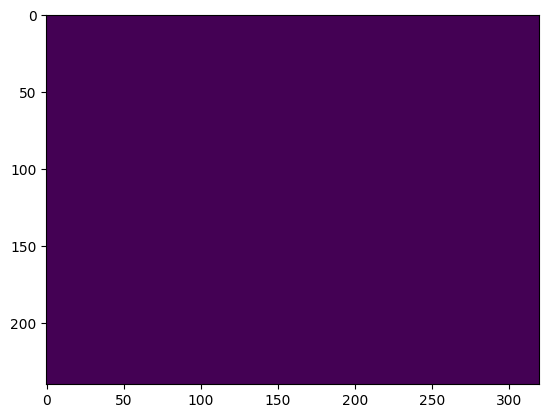

In [265]:
plt.imshow(img_LAB[:,:,2])

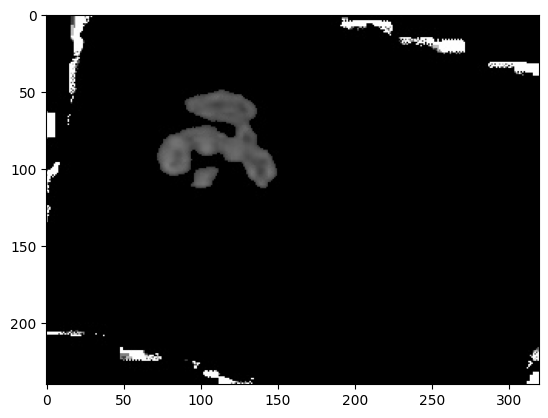

In [266]:
plt.imshow(img_gray)

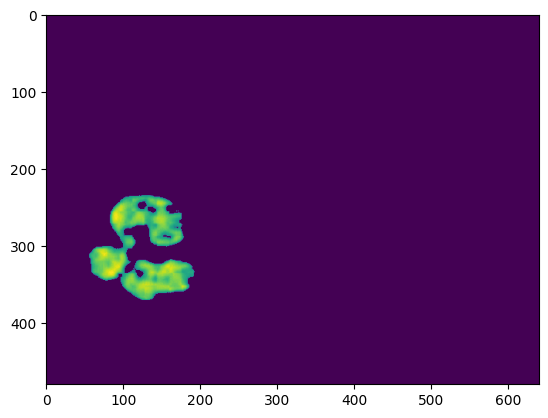

In [204]:
plt.imshow(masked_img)

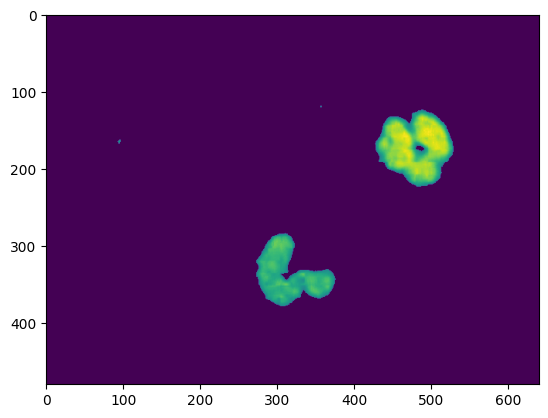

In [181]:
plt.imshow(masked_img)

In [151]:
cv.imwrite("new.jpg",cmyk_img)

True

In [152]:
image = cv.imread("new.jpg",cv2.IMREAD_UNCHANGED)

In [153]:
image.shape

(480, 640, 3)

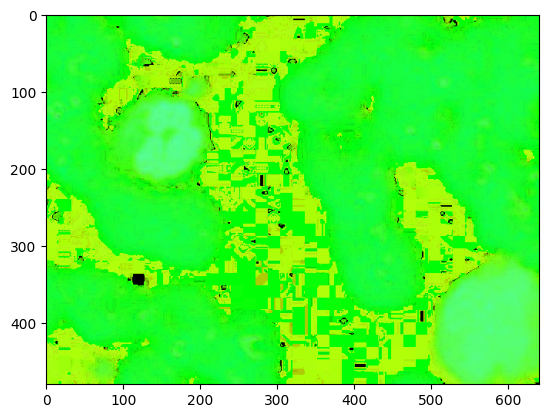

In [157]:
plt.imshow(image)

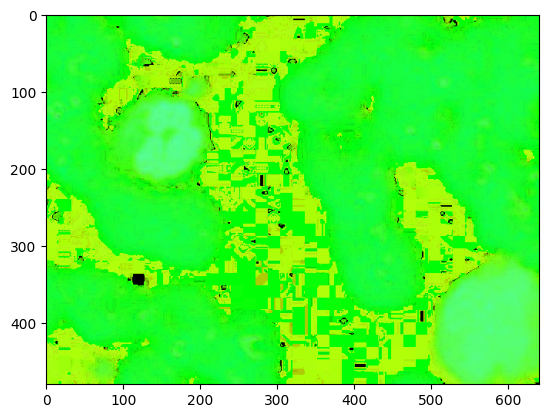

In [156]:
plt.imshow(image)

In [135]:
c,m,Y,k = cv.split(cmyk_img)

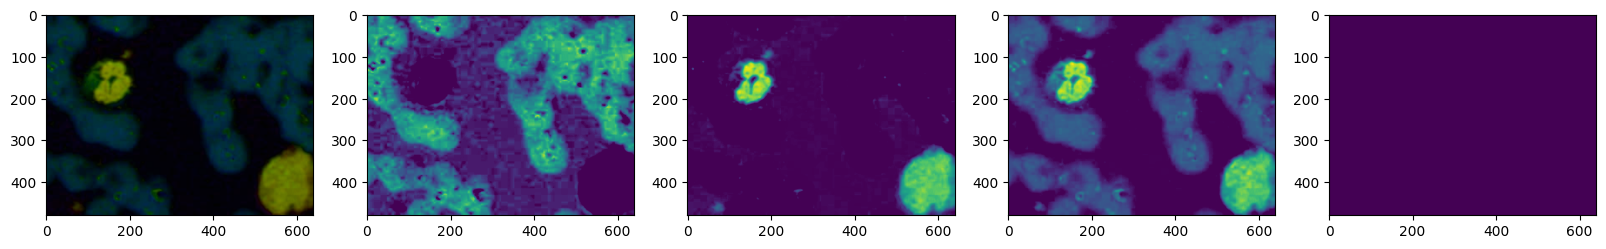

In [136]:
plt.figure(figsize=(20,10))
plt.subplot(151);plt.imshow(cmyk_img)
plt.subplot(152);plt.imshow(Y)
plt.subplot(153);plt.imshow(c)
plt.subplot(154);plt.imshow(m)
plt.subplot(155);plt.imshow(k)


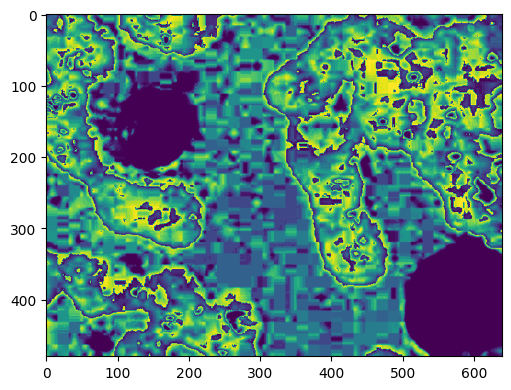

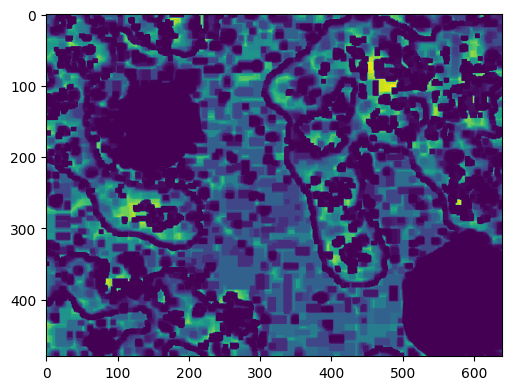

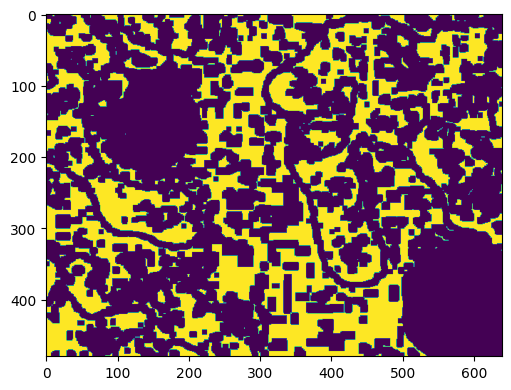

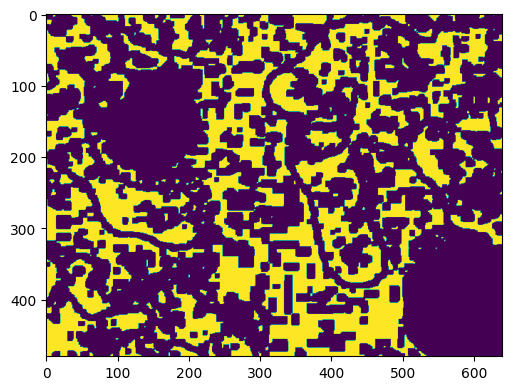

In [138]:
# Apply linear contrast stretching to the Y image
y_min = np.min(Y)
y_max = np.max(Y)
y_img_stretched = (Y - y_min) * (255.0 / (y_max - y_min)).astype(np.uint8)
#plt.subplot(151);plt.imshow(y_img_stretched)

# Apply histogram equalization to the Y image
y_img_equalized = cv2.equalizeHist(y_img_stretched)
enhanced_image = 2*y_img_stretched + y_img_equalized
plt.figure(figsize=(20,20))
plt.subplot(231);plt.imshow(enhanced_image)
min_filtered_img = cv2.erode(enhanced_image, np.ones((3, 3), np.uint8), iterations=3)

plt.figure(figsize=(20,20))
plt.subplot(232);plt.imshow(min_filtered_img)


# Otsu Thresholding
 
_, thresholded_img = cv2.threshold(min_filtered_img, 0, 255, cv.THRESH_BINARY+cv2.THRESH_OTSU)
#plt.subplot(153);
plt.figure(figsize=(20,20))
plt.subplot(233);plt.imshow(thresholded_img)


# Create disk-shaped structuring elements for opening and closing operations
open_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
close_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

# Apply morphological opening to remove small objects and smooth edges
wbc_img_opened = cv2.morphologyEx(thresholded_img, cv2.MORPH_OPEN, open_kernel)
plt.figure(figsize=(20,20))
plt.subplot(234);plt.imshow(wbc_img_opened)

# Apply morphological closing to fill holes and clear borders
wbc_img_closed = cv2.morphologyEx(wbc_img_opened, cv2.MORPH_CLOSE, close_kernel)
#plt.imshow(wbc_img_closed)

# Remove objects with area less than 30,000 pixels
contours, hierarchy = cv2.findContours(wbc_img_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    if cv2.contourArea(cnt) < 30:
        cv2.drawContours(wbc_img_closed, [cnt], -1, 0, -1)


<ipython-input-68-017f59e24157>:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122);plt.imshow(enhanced_cmyk_img)


'plt.subplot(122); plt.imshow(enhanced_cmyk_img)'

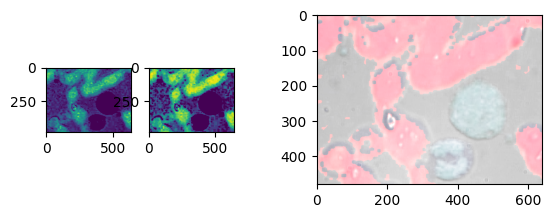

In [68]:
import cv2
import numpy as np

'''# Load the CMYK image using OpenCV
cmyk_img = cv2.imread('my_image_cmyk.jpg')'''

# Extract the Y component of the image (assuming Y is the first channel)
'''y_img = cmyk_img[:,:,0]'''




# Morphological Operations










plt.subplot(154);plt.imshow(wbc_img_closed)
# Save the result image using OpenCV
'''cv2.imwrite('wbc_processed.jpg', wbc_img_closed)'''



# Merge the enhanced Y component with the original CMYK channels
enhanced_cmyk_img = np.dstack((wbc_img_closed, c, m, k))

# Convert the enhanced CMYK image to RGB color space
#enhanced_rgb_img = cv2.cvtColor(enhanced_cmyk_img, cv2.COLOR_CMYK2RGB)
plt.subplot(122);plt.imshow(enhanced_cmyk_img)

# Define the CMYK to RGB conversion function
'''def cmyk_to_rgb(cmyk):
    c, m, y, k = cmyk / 255.0
    r = 255 * (1 - c) * (1 - k)
    g = 255 * (1 - m) * (1 - k)
    b = 255 * (1 - y) * (1 - k)
    return np.array([r, g, b])

'''

'''# Apply the CMYK to RGB conversion to each pixel using a lambda function
enhanced_rgb_img = np.apply_along_axis(lambda x: cmyk_to_rgb(x), axis=2, arr=enhanced_cmyk_img)
'''
'''# Scale the values in the RGB image to the range 0-255
enhanced_rgb_img = enhanced_rgb_img.astype(np.uint8)'''
'''plt.subplot(122); plt.imshow(enhanced_cmyk_img)'''


Nuclei Segmentation